In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install annoy
#!pip install -U sentence-transformers
#!pip install pandas dask

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552448 sha256=25baa5dfc446e49e54161885f88431a4be99d06221839635c390684b60d3a150
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
import json
import pandas as pd
import numpy as np
from google.colab import userdata


# Load data

In [3]:
cols = ['id', 'authors', 'doi', 'title', 'abstract']
data = []
file_name = '/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json'
file_name = '/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json'

with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['id'], doc['authors'], doc['doi'], doc['title'], doc['abstract']]
        data.append(lst)

df_data = pd.DataFrame(data=data, columns=cols)

print(df_data.shape)



(2440876, 5)


,id,authors,doi,title,abstract
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",10.1103/PhysRevD.76.013009,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...
1,0704.0002,Ileana Streinu and Louis Theran,None,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-..."
2,0704.0003,Hongjun Pan,None,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...
3,0704.0004,David Callan,None,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,None,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...


In [4]:
df_data['prepared_text'] = '{title}: ' + df_data['title'] + ' {abstract}: ' + df_data['abstract']

In [5]:
df_data['prepared_text'] = df_data.prepared_text.apply(lambda x: x.replace("\n", " "))
df_data['prepared_text'] = df_data.prepared_text.apply(lambda x: x.lower())


In [6]:
# prompt: drop the title, abstract, and doi columns

df_data.drop(['title', 'abstract', 'doi', 'authors'], axis=1, inplace=True)


In [7]:
# prompt: create a word frequency dataframe for all the words in the prepared_text column

import pandas as pd
word_counts = {}

for text in df_data['prepared_text']:
    for word in text.split():
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] += 1

word_frequency_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_frequency_df.sort_values(by=['count'], ascending=False, inplace=True)
word_frequency_df.head()


,count
the,25632267
of,15964129
and,9670233
a,9021580
in,8106325


In [13]:
# prompt: print some statistics about the word frequency dataframe

print(f"Number of unique words: {word_frequency_df.shape[0]}")
print(f"Minimum word count: {word_frequency_df['count'].min()}")
print(f"Maximum word count: {word_frequency_df['count'].max()}")
print(f"Average word count: {word_frequency_df['count'].mean()}")
print(f"Median word count: {word_frequency_df['count'].median()}")
print(f"Standard deviation of word counts: {word_frequency_df['count'].std()}")
word_frequency_df.describe()


Number of unique words: 5281001
Minimum word count: 1
Maximum word count: 25632267
Average word count: 70.2839457898228
Median word count: 1.0
Standard deviation of word counts: 16213.412755624957


,count
count,5.281001e+06
mean,7.028395e+01
std,1.621341e+04
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.563227e+07


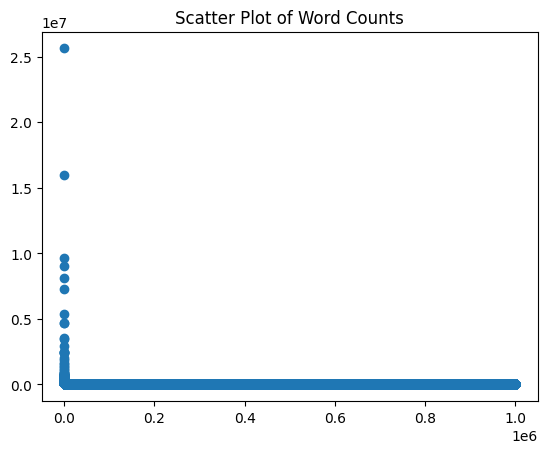

In [20]:
# prompt: print on a scatter plot

import matplotlib.pyplot as plt

y = word_frequency_df['count'].head(1000000)
x = range(len(y))

plt.scatter(x, y)
#plt.ylabel('Word Count')
#plt.xlabel('Word Index')
plt.title('Scatter Plot of Word Counts')
plt.show()


In [17]:
# prompt:  useful charts for the word frequency dataframe

import matplotlib.pyplot as plt
# Histogram of word counts
#plt.hist(word_frequency_df['count'], bins=100)
#plt.xlabel('Word Count')
#plt.ylabel('Frequency')
#plt.title('Histogram of Word Counts')
#plt.show()

# Boxplot of word counts
#plt.boxplot(word_frequency_df['count'])
#plt.ylabel('Word Count')
#plt.title('Boxplot of Word Counts')
#plt.show()

# Cumulative distribution of word counts
sorted_counts = word_frequency_df['count'].head(10000)
cumulative_counts = sorted_counts.cumsum()
plt.plot(cumulative_counts)
#plt.xlabel('Word Index')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Distribution of Word Counts')
plt.show()


ValueError: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

# Data Statistics

In [ ]:
# All words in a list form
df_data['chunk_words'] = df_data.prepared_text.apply(lambda x: x.split())

In [ ]:
#LEN fo the raw words in list form
df_data['words_raw_count'] = df_data.chunk_words.apply(lambda x: len(x))

In [ ]:
#Set of all the words
df_data['word_set'] = df_data.chunk_words.apply(lambda x: list(set(x)))

In [ ]:
#count of the set
df_data['word_set_count'] = df_data.word_set.apply(lambda x: len(x))

In [ ]:
unique_set = set()
for index, row in df_data.iterrows():
  for word in row['word_set']:
    unique_set.add(word)
  if (index % 200000 == 0):
    print(index)

words = list(unique_set)
df_words = pd.DataFrame(words)
df_words.head()

0
200000
400000
600000
800000
1000000
1200000
1400000
1600000
1800000
2000000
2200000
2400000


,0
0,[eu/fe]=+1.69+/-0.05)
1,"pyrenees,"
2,au/mos2/sio2/p-si
3,$(1+n)$-vortex
4,"$s_c=\frac{n}{2}-\frac{4}{p-1}\in(0,2)$,"


In [ ]:
df_words.rename(columns={ df_words.columns[0]: "Token" }, inplace = True)
df_words = df_words.assign(count=0)
df_words.head()

,Token,count
0,($0.1$--$100$~gev),0
1,4.25{\deg},0
2,lavse,0
3,multi-scale-model-to-model,0
4,(rxte/pca),0


In [ ]:
df_data['cat_cut'] = [x.split('-')[0] for x in df_data['cat_cut']]


In [ ]:
df_data.head()

,id,authors,doi,title,abstract,categories,prepared_text,chunk_words,words_raw_count,word_set,word_set_count,cat_cut
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",10.1103/PhysRevD.76.013009,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,{title}: calculation of prompt diphoton produc...,"[{title}:, calculation, of, prompt, diphoton, ...",154,"[is, reliable., contributions, can, next-to-ne...",101,hep
1,0704.0002,Ileana Streinu and Louis Theran,None,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,{title}: sparsity-certifying graph decompositi...,"[{title}:, sparsity-certifying, graph, decompo...",120,"[attention, previous, hendrickson., it, years....",78,math
2,0704.0003,Hongjun Pan,None,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,{title}: the evolution of the earth-moon syste...,"[{title}:, the, evolution, of, the, earth-moon...",160,"[is, which, for, s^(-2)., and, friction, years...",91,physics
3,0704.0004,David Callan,None,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO,{title}: a determinant of stirling cycle numbe...,"[{title}:, a, determinant, of, stirling, cycle...",48,"[stirling, {title}:, numbers, cycle, single-so...",33,math
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,None,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA,{title}: from dyadic $\lambda_{\alpha}$ to $\l...,"[{title}:, from, dyadic, $\lambda_{\alpha}$, t...",44,"[how, is, $\alpha\ge, {title}:, norm,, consequ...",32,math


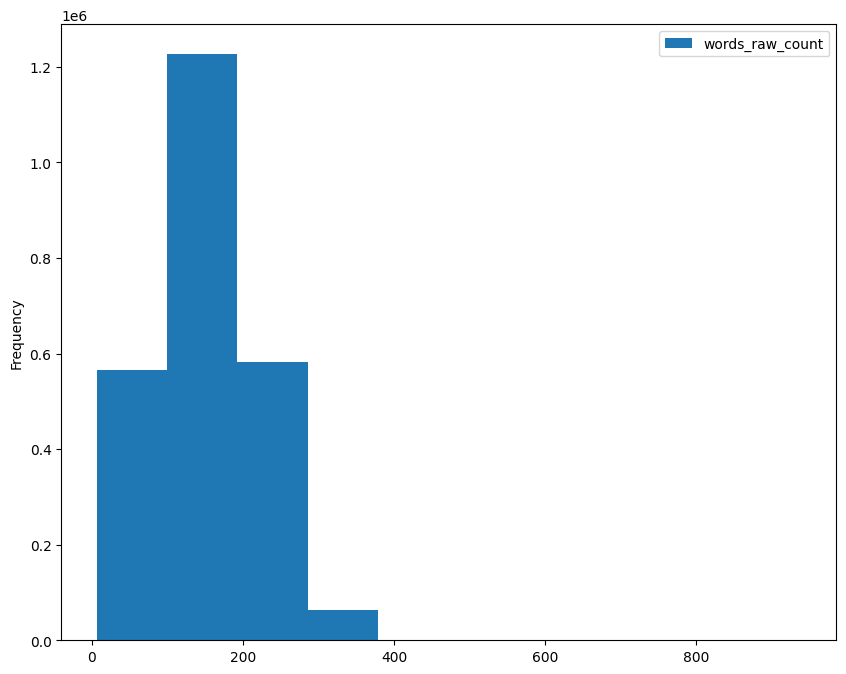

In [ ]:
ax = df_data.plot.hist(column=["words_raw_count"], figsize=(10, 8))


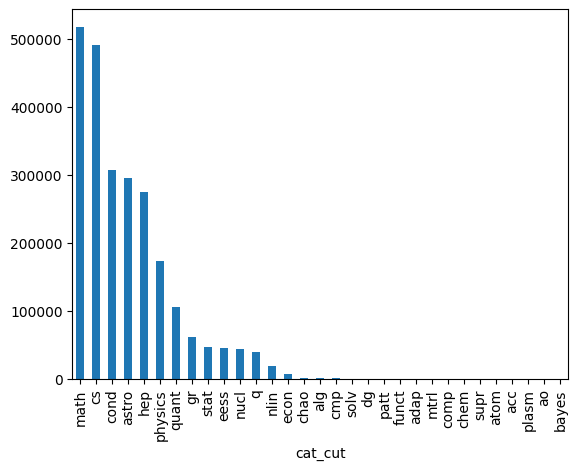

In [ ]:
#df_data.plot.hist(column=["categories"], figsize=(10, 8))
bx = df_data['cat_cut'].value_counts().plot(kind='bar')


In [ ]:
print(df_data['words_raw_count'].min())
print(df_data['words_raw_count'].max())
print(df_data['words_raw_count'].mean())
print(df_data['words_raw_count'].std())
#print(len(unique_set))


10
594
152.01587987078696
64.63410431192065


In [ ]:
#df_data.loc[df_data['words_raw_count'] == 7]

df_data.drop(index=df_data.loc[df_data['words_raw_count'] < 10].index, inplace=True)
df_data.drop(index=df_data.loc[df_data['words_raw_count'] > 600].index, inplace=True)





In [ ]:
df_data.head()

,id,authors,doi,title,abstract,prepared_text,chunk_words,words_raw_count,word_set,word_set_count
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",10.1103/PhysRevD.76.013009,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,{title}: calculation of prompt diphoton produc...,"[{title}:, calculation, of, prompt, diphoton, ...",154,"[next-to-next-to-leading, fully, data, predict...",101
1,0704.0002,Ileana Streinu and Louis Theran,None,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",{title}: sparsity-certifying graph decompositi...,"[{title}:, sparsity-certifying, graph, decompo...",120,"[theory, by, pebble, years., our, $(k,\ell)$-s...",78
2,0704.0003,Hongjun Pan,None,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,{title}: the evolution of the earth-moon syste...,"[{title}:, the, evolution, of, the, earth-moon...",160,"[behavior, slowing, by, evidence., data, far, ...",91
3,0704.0004,David Callan,None,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,{title}: a determinant of stirling cycle numbe...,"[{title}:, a, determinant, of, stirling, cycle...",48,"[proof, numbers, acyclic, certain, lattice, un...",33
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,None,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,{title}: from dyadic $\lambda_{\alpha}$ to $\l...,"[{title}:, from, dyadic, $\lambda_{\alpha}$, t...",44,"[how, this, 0$,, norm,, using, result, terms, ...",32


In [ ]:
df_data.words_raw_count.sum()


370307187

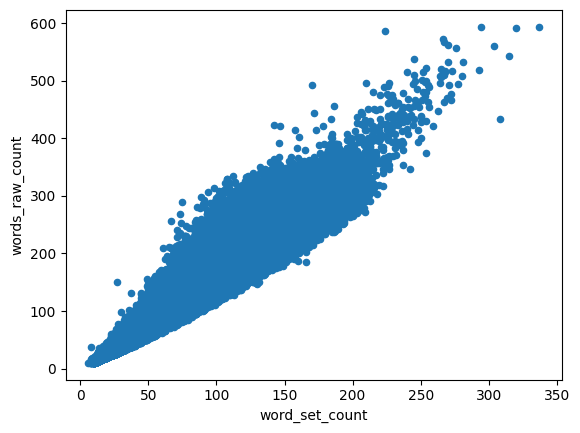

In [ ]:
df_data.plot.scatter(y="words_raw_count", x="word_set_count");


In [ ]:
from collections import Counter


In [ ]:
result = []
for index, row in df_data.iterrows():
  result.append[Counter(row.chunk_words)]
  if (index % 100000 == 0):
    print(index)



#y = pd.DataFrame.from_dict(Counter(df_data.chunk_words[1]), orient='index')


TypeError: 'builtin_function_or_method' object is not subscriptable

# Embed data

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("thenlper/gte-base")
model.max_seq_length = 512

In [ ]:
#for ALL data
chunk_list = list(df_data['prepared_text'])
embeddings = model.encode(chunk_list)
df_data['embedding'] = embeddings.tolist()

In [ ]:
#For subset Data
df2 = df_data.loc[1000000:1999999]
chunk_list = list(df2['prepared_text'])
embeddings = model.encode(chunk_list, batch_size=256, show_progress_bar=True)
df2['embedding'] = embeddings.tolist()

In [ ]:
header = ["id", "title", "embedding"]
df2.to_csv('/content/drive/My Drive/embedded_gte-base-2.4M.csv', columns = header, index=False)

# Build Index

In [ ]:
import pandas as pd
from annoy import AnnoyIndex
import gc
import numpy as np

annoy_model = AnnoyIndex(768, metric='angular')
#to Build model on disk
annoy_model.on_disk_build('/media/embeds_on_disk_gte.ann')

df_data_1M = pd.read_csv('/content/drive/MyDrive/Information Storage Project Files/GTE-Base Embeddings/embedded_gte-base-1M.csv')
df_data_1M['embedding'] = df_data_1M['embedding'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, count=-1, sep=', '))

for i, row in df_data_1M.iterrows():
    annoy_model.add_item(i, row['embedding'])
del df_data_1M
gc.collect

df_data_2M = pd.read_csv('/content/drive/MyDrive/Information Storage Project Files/GTE-Base Embeddings/embedded_gte-base-2M.csv')
df_data_2M['embedding'] = df_data_2M['embedding'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, count=-1, sep=', '))

for i, row in df_data_2M.iterrows():
    annoy_model.add_item(i+1000000, row['embedding'])
del df_data_2M
gc.collect

df_data_24M = pd.read_csv('/content/drive/MyDrive/Information Storage Project Files/GTE-Base Embeddings/embedded_gte-base-2.4M.csv')
df_data_24M['embedding'] = df_data_24M['embedding'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, count=-1, sep=', '))

for i, row in df_data_24M.iterrows():
    annoy_model.add_item(i+2000000, row['embedding'])
del df_data_24M
gc.collect


<function gc.collect(generation=2)>

In [ ]:
annoy_model.build(500, n_jobs=-1)

True

In [ ]:
gc.collect

<function gc.collect(generation=2)>

In [ ]:
annoy_model.unload()
#annoy_model.save('/media/embeds_on_disk_gte1.ann')
#annoy_model.save('/content/drive/My Drive/embeds_gte-base-all.ann')

True

In [ ]:
annoy_model1 = AnnoyIndex(768, metric='angular')
annoy_model1.load('/home/embeds_on_disk_gte.ann', prefault=True)


KeyboardInterrupt: 

In [ ]:
print(annoy_model1.get_n_items)

<built-in method get_n_items of annoy.Annoy object at 0x78abfb1a26f0>
